# Chapter 17: Representation Learning and Generative Learning Using Autoencoders and GANs

**Tujuan:** Memahami autoencoder (AE), variational autoencoder (VAE), dan Generative Adversarial Networks (GANs) untuk representasi dan generative modeling.

---

## 1. Autoencoders (AE)

- **Arsitektur**: Encoder → Bottleneck → Decoder  
- **Tujuan**: Belajar representasi terkompresi (latent code) dengan meminimalkan rekonstruksi  
- **Loss**: Mean Squared Error (MSE) antara input & output

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

### 1.1 Siapkan data: MNIST (flatten)

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test .astype("float32") / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test  = x_test.reshape(-1, 28*28)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 1.2 Bangun autoencoder

In [3]:
encoding_dim = 64

input_img = layers.Input(shape=(784,))
encoded   = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded   = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = models.Model(input_img, decoded)
encoder     = models.Model(input_img, encoded)

# Decoder untuk sampling
encoded_input = layers.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder       = models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

### 1.3 Latih

In [4]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0974 - val_loss: 0.0321
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0290 - val_loss: 0.0208
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0196 - val_loss: 0.0153
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0118
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0079
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0050


### 1.4 Visualisasi rekonstruksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


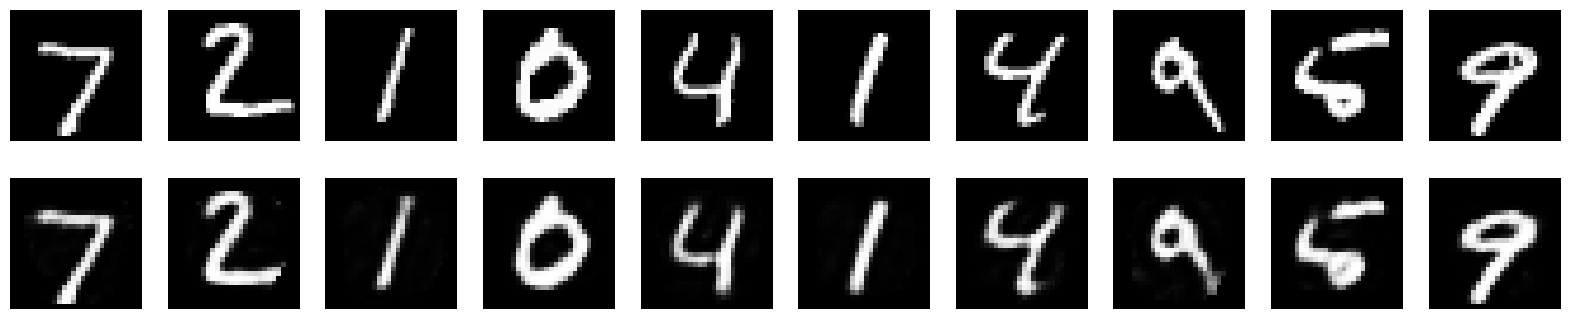

In [5]:
decoded_imgs = autoencoder.predict(x_test[:10])
plt.figure(figsize=(20,4))
for i in range(10):
    # asli
    ax = plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    # rekonstruksi
    ax = plt.subplot(2,10,i+1+10)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

## 2. Denoising Autoencoder
- Menambahkan noise ke input, target tetap bersih → AE belajar menghilangkan noise

### 2.1 Tambah noise

In [6]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy  = x_test  + noise_factor * np.random.normal(size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy,  0., 1.)

### 2.2 Latih AE denoising

In [7]:
denoise_ae = models.clone_model(autoencoder)
denoise_ae.compile(optimizer='adam', loss='mse')
denoise_ae.fit(
    x_train_noisy, x_train,
    epochs=10, batch_size=256,
    shuffle=True, validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0958 - val_loss: 0.0430
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0397 - val_loss: 0.0306
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0296 - val_loss: 0.0260
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0257 - val_loss: 0.0234
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0214
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0213 - val_loss: 0.0201
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186 - val_loss: 0.0181
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - val_loss: 0.0177


### 2.3 Visualisasi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


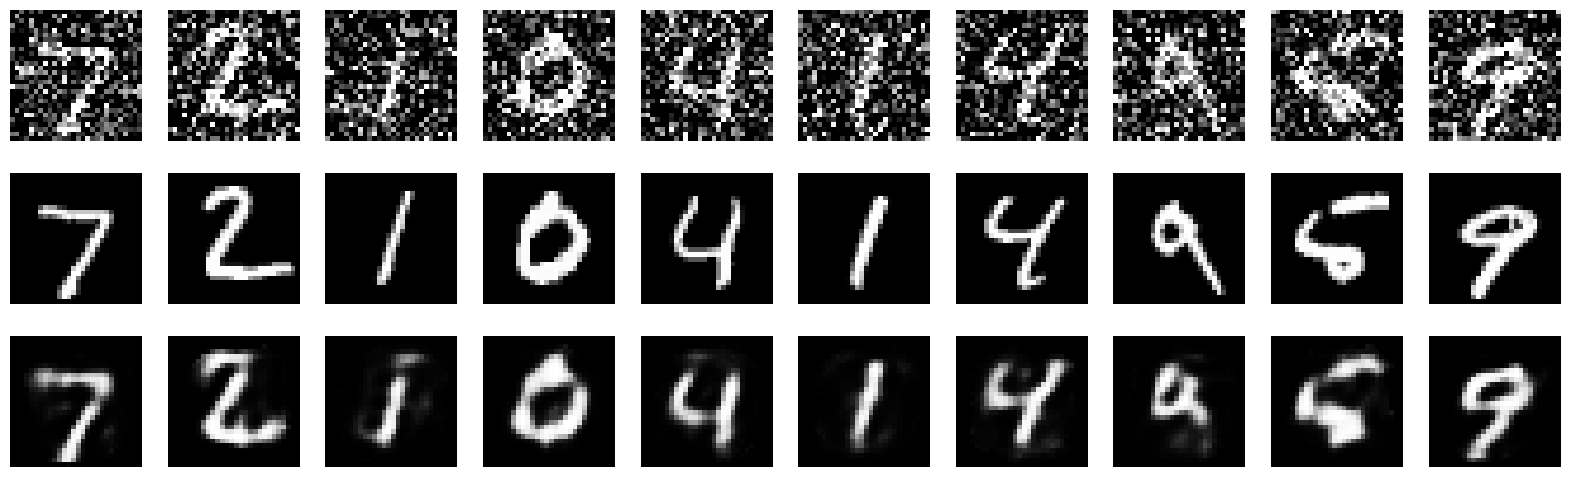

In [8]:
decoded_dn = denoise_ae.predict(x_test_noisy[:10])
plt.figure(figsize=(20,6))
for i in range(10):
    # noisy input
    ax = plt.subplot(3,10,i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    # clean target
    ax = plt.subplot(3,10,i+1+10)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    # denoised output
    ax = plt.subplot(3,10,i+1+20)
    plt.imshow(decoded_dn[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

## 3. Variational Autoencoder (VAE)

- Memodelkan distribusi laten:
$
\mathcal{N}(\mu, \sigma^2)
$
di mana $\mu$ dan $\sigma^2$ adalah parameter dari distribusi Gaussian yang dipelajari oleh model.

- Loss = reconstruction loss + KL divergence

### 3.1 Bangun VAE

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers

latent_dim = 2

# Encoder: outputs (z_mean, z_log_var, z)
class Encoder(layers.Layer):
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.dense1    = layers.Dense(256, activation="relu")
        self.z_mean    = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

    def call(self, inputs):
        x = self.dense1(inputs)
        mean = self.z_mean(x)
        log_var = self.z_log_var(x)
        eps = tf.random.normal(shape=tf.shape(mean))
        z = mean + tf.exp(0.5 * log_var) * eps
        return mean, log_var, z

# Decoder
class Decoder(layers.Layer):
    def __init__(self, original_dim, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(256, activation="relu")
        self.out   = layers.Dense(original_dim, activation="sigmoid")

    def call(self, z):
        x = self.dense(z)
        return self.out(x)

# VAE model that ties them together and adds the VAE‐loss
class VAE(Model):
    def __init__(self, original_dim, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        self.original_dim = original_dim

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        x_decoded = self.decoder(z)

        # --- add_loss INSIDE call, using only KerasLayers/Keras ops ---
        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            losses.mse(inputs, x_decoded) * self.original_dim
        )
        # KL divergence
        kl = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        self.add_loss(recon_loss + kl)

        return x_decoded

### 3.2 Latih VAE

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test  = x_test .reshape(-1, 28*28).astype("float32") / 255.0

vae = VAE(original_dim=784, latent_dim=latent_dim)
vae.compile(optimizer=optimizers.Adam())
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=256,
        validation_data=(x_test, x_test))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 82.7579 - val_loss: 46.5940
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45.5648 - val_loss: 42.2692
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 42.1285 - val_loss: 41.0112
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 41.2117 - val_loss: 40.3003
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40.5602 - val_loss: 39.8122
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.9657 - val_loss: 39.4852
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.5498 - val_loss: 39.1429
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.3566 - val_loss: 38.9170
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.9827 - val_loss: 38.6631
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 38.8142 - val_loss: 38.4868


### 3.3 Visualisasi latent space

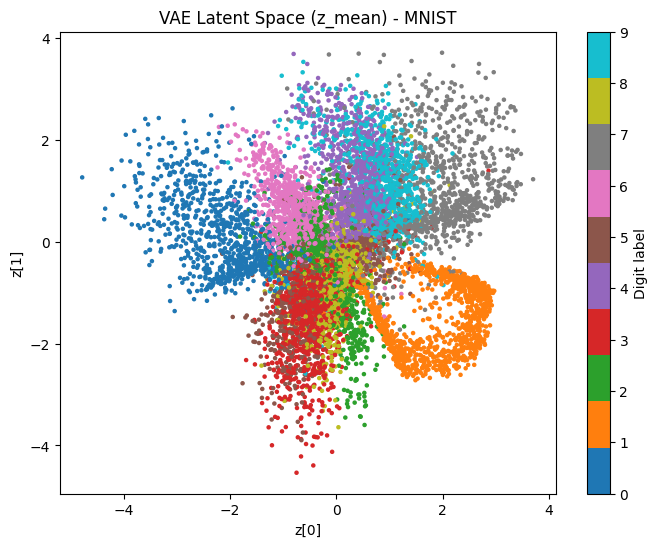

In [11]:
# Load dan siapkan data MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test = x_test.reshape(-1, 784)

# Panggil encoder secara langsung
z_mean, _, _ = vae.encoder(x_test)

# Visualisasi 2D
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', s=5)
plt.colorbar(sc, ticks=range(10), label='Digit label')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("VAE Latent Space (z_mean) - MNIST")
plt.show()

## 4. Generative Adversarial Networks (GANs)

* **Generator (G):** menghasilkan data palsu dari noise $z \sim p_z(z)$
* **Discriminator (D):** membedakan apakah data berasal dari dataset asli atau dari generator

---

### Minimax Game

GAN dilatih menggunakan permainan dua pemain (minimax game) antara $G$ dan $D$:

$$
\min_G \max_D \, \mathbb{E}_{x \sim p_{\text{data}}} [\log D(x)] + \mathbb{E} {z \sim p_z} [\log (1 - D(G(z)))]
$$

* $D(x)$: probabilitas bahwa $x$ adalah data asli
* $G(z)$: data palsu yang dihasilkan dari noise $z$
* Tujuan:

  * $D$: memaksimalkan kemampuan membedakan asli vs palsu
  * $G$: meminimalkan kemampuan $D$, alias menipu $D$

### 4.1 Siapkan data MNIST

In [11]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # [-1,1]
x_train = x_train.reshape(-1, 28*28)

### 4.2 Bangun Generator

In [12]:
def make_generator_model():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(784, activation='tanh')
    ])
    return model

### 4.3 Bangun Discriminator

In [13]:
def make_discriminator_model():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 4.4 Gabungkan untuk GAN

In [14]:
discriminator.trainable = False
gan_input = layers.Input(shape=(100,))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = models.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

### 4.5 Latih sederhana

In [16]:
import time
batch_size = 256
epochs = 100
half_batch = batch_size // 2

for epoch in range(epochs):
    # Latih D
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_imgs = x_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    fake_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch,1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch,1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Latih G via GAN
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch % 2000 == 0:
        print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0 [D loss: 6.1887] [G loss: 0.0006]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━

### 4.6 Visualisasi sampel palsu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


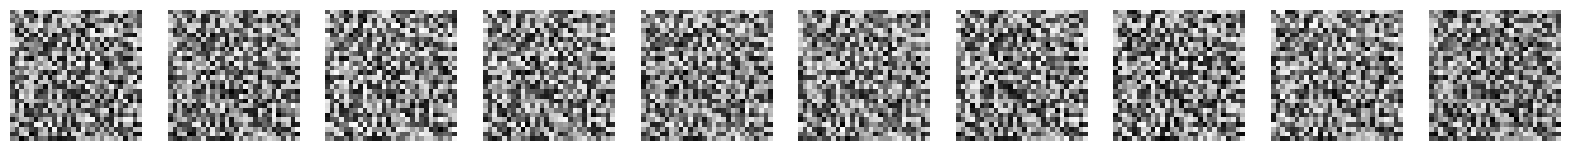

In [17]:
noise = np.random.normal(0,1,(10,100))
gen_imgs = generator.predict(noise)
plt.figure(figsize=(20,4))
for i in range(10):
    ax = plt.subplot(2,10,i+1)
    plt.imshow(gen_imgs[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
plt.show()

# Ringkasan Chapter 17
1. Autoencoder belajar representasi terkompresi & rekonstruksi.

2. Denoising AE menghapus noise dari data.

3. Variational AE mempelajari distribusi laten.

4. GANs menciptakan data baru via kompetisi Generator vs Discriminator.